In [422]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from scipy.stats import kruskal
from sklearn.model_selection import cross_validate

In [423]:
random_state = 42

In [424]:
df = pd.read_csv('dataset.csv')

In [425]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<AxesSubplot: xlabel='charges', ylabel='bmi'>

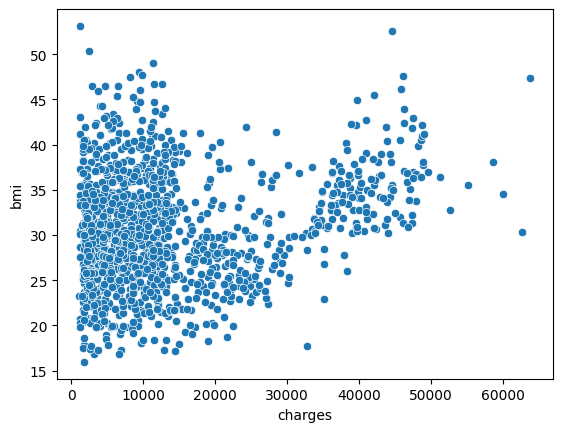

In [426]:
sns.scatterplot(data=df, x='charges', y='bmi')

In [427]:
df.loc[df['bmi'] < 18.5 , 'grade'] = 'underweight'
df.loc[df['bmi'].between(18.5, 25, 'both'), 'grade'] = 'good'
df.loc[df['bmi'].between(25, 30, 'right'), 'grade'] = 'overweight'
df.loc[df['bmi'] > 30 , 'grade'] = 'obesity'
df.drop('bmi',axis=1, inplace=True)

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
 6   grade     1338 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 73.3+ KB


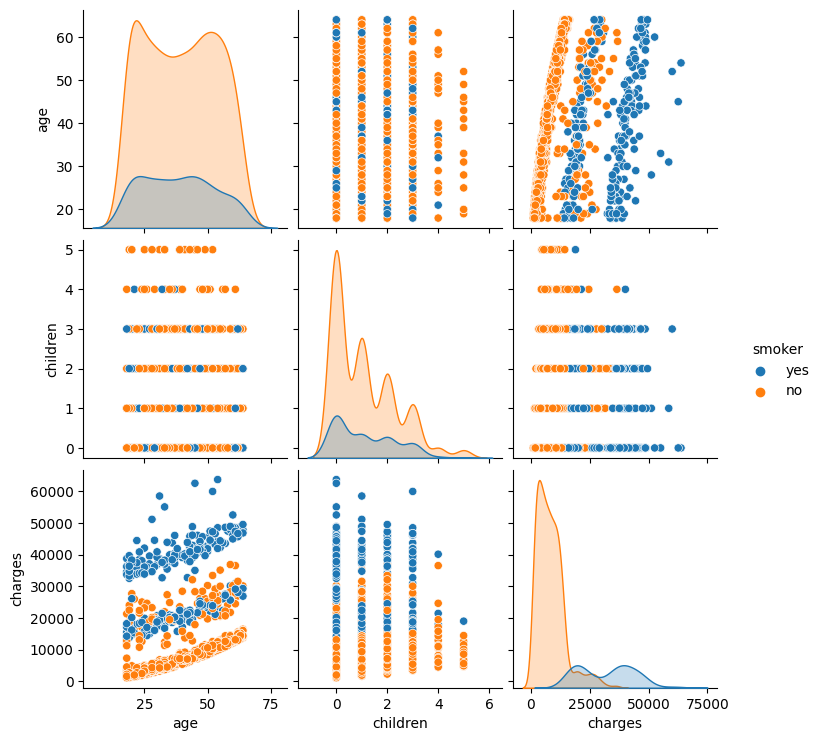

In [429]:
sns.pairplot(data=df, hue='smoker')
plt.show()

## Est-ce que la région a un impact sur les charges ?

In [435]:
# Les exemples sont équitablement distribués parmi toutes les régions
df.value_counts('region')

region
southeast    364
northwest    325
southwest    325
northeast    324
dtype: int64

<AxesSubplot: xlabel='region', ylabel='charges'>

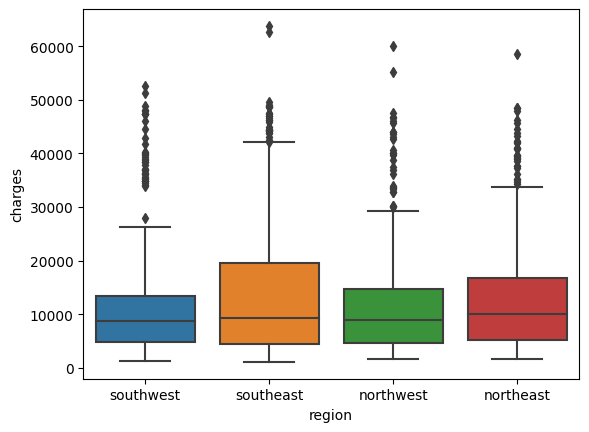

In [434]:
sns.boxplot(data=df, x='region', y='charges')

In [437]:
list_df = [df[df['region'] == region]['charges'] for region in df.region.unique()]

In [439]:
kruskal(*list_df)

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

## Modélisation

In [457]:
df.drop_duplicates(inplace=True)
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X[['smoker']])
dummy = DummyRegressor()
X_train.head()
dummy.fit(X_train, y_train)


In [ ]:
cross_validate(dummy, X_train, y_train)

In [452]:
X_train.value_counts('region')/len(X_train)

region
southeast    0.272007
northwest    0.242958
southwest    0.242958
northeast    0.242077
dtype: float64

In [453]:
X_test.value_counts('region')/len(X_test)

region
southeast    0.273632
northeast    0.243781
southwest    0.243781
northwest    0.238806
dtype: float64

## Feature selection

In [404]:
lasso = Lasso()

In [338]:
onehot = OneHotEncoder(drop="if_binary")
std = StandardScaler()
onehot_col_std = make_column_transformer((onehot, ['sex', 'region', 'smoker', 'grade']), (std, ['age',  'children']))
# onehot_col = make_column_transformer((onehot, ['sex', 'region', 'smoker']),remainder='passthrough')

In [405]:
feature_selection = make_pipeline(onehot_col_std, lasso)

In [407]:
feature_selection.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'region', 'smoker',
                                                   'grade']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children'])])),
                ('lasso', Lasso())])

In [420]:
col = pd.get_dummies(X_train).columns
values = feature_selection[1].coef_

dict(zip(col, values))

{'age': -44.96557134159068,
 'children': 559.9111456569351,
 'sex_female': 88.6293653610966,
 'sex_male': -0.3164441600906793,
 'smoker_no': -165.23638272113766,
 'smoker_yes': 23069.939151845076,
 'region_northeast': -425.160162867011,
 'region_northwest': 4013.1864989373275,
 'region_southeast': 0.0,
 'region_southwest': -3246.4998690373277,
 'grade_good': 3455.208566382114,
 'grade_obesity': 644.8615260411112}

In [417]:
col.shape

(12,)

In [339]:
# preprocessing = make_pipeline(onehot_col)
# preprocessing_poly = make_pipeline(onehot_col, PolynomialFeatures())
preprocessing_poly_std = make_pipeline(onehot_col_std, PolynomialFeatures())


In [340]:
lr = LinearRegression()
# lr_pipe = make_pipeline(preprocessing_poly, lr)
lr_pipe_std = make_pipeline(preprocessing_poly_std, lr)
lr_pipe_std.fit(X_train, y_train)





0.8953462998389315

In [470]:
cross_validate(lr_pipe_std, X_train, y_train, cv=5)

{'fit_time': array([0.01365185, 0.01923299, 0.01833701, 0.034477  , 0.02841711]),
 'score_time': array([0.00212097, 0.00177002, 0.00186229, 0.00747085, 0.00188303]),
 'test_score': array([0.81634744, 0.87769156, 0.86493247, 0.84419907, 0.82527922])}

In [466]:
from sklearn.model_selection import KFold
skf = KFold(shuffle=True, random_state=42)


In [341]:
lr_pipe_std.score(X_train,y_train)

0.8535695724594091

In [342]:
lr_pipe_poly = make_pipeline(preprocessing_poly_std, lr)
lr_pipe_poly.fit(X_train, y_train)
lr_pipe_poly.score(X_test,y_test)

0.8953462998389315

In [343]:
el = ElasticNet(random_state=42, tol=0.0001, max_iter=10000)
# el = ElasticNet()
el_pipe_poly = make_pipeline(preprocessing_poly_std, el)
el_pipe_poly.fit(X_train, y_train)
el_pipe_poly.score(X_test,y_test)

0.5993992125526072

In [344]:
el_pipe_poly.score(X_train, y_train)

0.6120349907283672

In [345]:
alpha_range = np.linspace(0.0001, 100, 500)
l1_ratio_range = np.linspace(0, 1, 500)
param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':l1_ratio_range, 'pipeline__polynomialfeatures__degree': [1,2,3]}
elastic_grid = RandomizedSearchCV(el_pipe_poly, param_distributions, n_iter=500, cv=5, random_state=random_state, verbose=0)

In [346]:
# el_pipe_poly.get_params()

In [347]:
elastic_grid.fit(X_train, y_train)

/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.516e+10, tolerance: 1.138e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/ml_api/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.672e+10, tolerance: 1.168e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('onehotencoder',
                                                                                                OneHotEncoder(drop='if_binary'),
                                                                                                ['sex',
                                                                                                 'region',
                                                                                                 'smoker',
                                                                                                 'grade']),
                                                                                               ('standardscaler',
                                                                                                StandardScaler(),
                                                                                                ['age',
                                                                                                 'children'])])),
                                                              ('polynomialfeatures',
                                                               PolynomialFeatures())])),
                                             ('elasticnet',
                                              ElasticNet(max_i...
       0.94188377, 0.94388778, 0.94589178, 0.94789579, 0.9498998 ,
       0.95190381, 0.95390782, 0.95591182, 0.95791583, 0.95991984,
       0.96192385, 0.96392786, 0.96593186, 0.96793587, 0.96993988,
       0.97194389, 0.9739479 , 0.9759519 , 0.97795591, 0.97995992,
       0.98196393, 0.98396794, 0.98597194, 0.98797595, 0.98997996,
       0.99198397, 0.99398798, 0.99599198, 0.99799599, 1.        ]),
                                        'pipeline__polynomialfeatures__degree': [1,
                                                                                 2,
                                                                                 3]},
                   random_state=42)

In [348]:
elastic_grid.best_score_

0.8402199296551316

In [349]:
elastic_grid.best_params_

{'pipeline__polynomialfeatures__degree': 2,
 'elasticnet__l1_ratio': 0.9138276553106212,
 'elasticnet__alpha': 0.2005006012024048}

In [350]:
elastic_grid.score(X_test, y_test)

0.8888794603997002

In [370]:
alpha_range = np.linspace(.10,.30,100)

param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[0.92], 'pipeline__polynomialfeatures__degree': [2]}
elastic_grid_opti = GridSearchCV(el_pipe_poly, param_distributions, cv=5, verbose=0)

In [371]:
elastic_grid_opti.fit(X_train, y_train)
elastic_grid_opti.best_score_

0.8443664976814095

In [372]:
elastic_grid_opti.score(X_test, y_test)

0.8956973298969844

In [373]:
residual = np.abs(elastic_grid_opti.predict(X_train) - y_train)

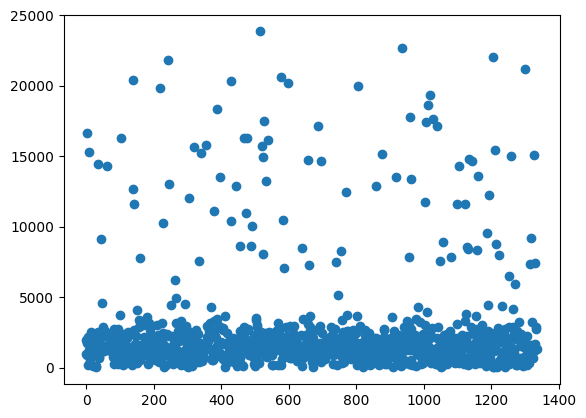

In [374]:
plt.scatter(X_train.index, residual)

In [375]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

X_s = sm.add_constant(pd.get_dummies(X_train))
model = sm.OLS(y_train, X_s)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     297.7
Date:                Fri, 06 Jan 2023   Prob (F-statistic):          2.95e-299
Time:                        09:49:46   Log-Likelihood:                -10815.
No. Observations:                1069   AIC:                         2.165e+04
Df Residuals:                    1058   BIC:                         2.171e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3122.2417    267.328     11.679      0.000    2597.689    3646.794
age                 246.9150     13.362     18.479      0.000     220.697     273.133
children            540.8692    154.702      3.496      0.000     237.312     844.426
sex_female         1586.0628    232.726      6.815      0.000    1129.405    2042.720
sex_male           1536.1789    223.923      6.860      0.000    1096.794    1975.563
smoker_no         -9977.8661    247.069    -40.385      0.000   -1.05e+04   -9493.066
smoker_yes          1.31e+04    287.451     45.573      0.000    1.25e+04    1.37e+04
region_northeast   1225.5560    333.366      3.676      0.000     571.422    1879.690
region_northwest    752.9821    329.700      2.284      0.023     106.042    1399.922
region_southeast    653.4873    324.695      2.013      0.044      16.368    1290.607
region_southwest    490.2163    328.782      1.491      0.136    -154.924    1135.356
grade_good          283.4979    510.427      0.555      0.579    -718.067    1285.063
grade_obesity      4731.9996    454.286     10.416      0.000    3840.596    5623.403
grade_overweight    718.4775    471.654      1.523      0.128    -207.006    1643.960
grade_underweight -2611.7332   1262.333     -2.069      0.039   -5088.694    -134.773
==============================================================================
Omnibus:                      281.098   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.529
Skew:                           1.391   Prob(JB):                    1.53e-151
Kurtosis:                       5.802   Cond. No.                     1.58e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.39e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [376]:
influence = results.get_influence().cooks_distance[0]
n = X_train.shape[0]
p = X_train.shape[1]

seuil_dcook = 4/(n-p)

In [377]:
analyses = X_train.copy()

In [378]:
analyses['cook_distance'] = influence

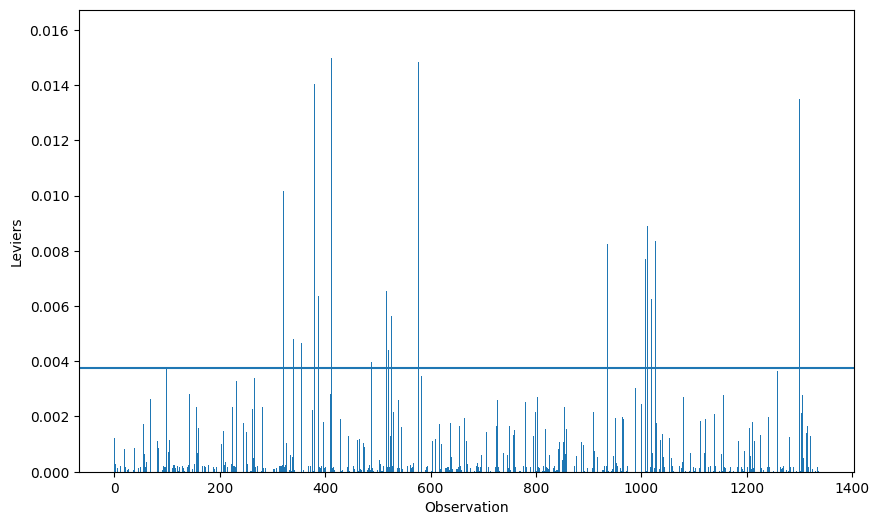

In [400]:
plt.figure(figsize=(10,6))
plt.bar(analyses.index, analyses['cook_distance'])
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.axhline(seuil_dcook)
plt.show()

In [380]:
X_train_cook = X_train[~(analyses['cook_distance'] > seuil_dcook)]
y_train_cook = y_train[~(analyses['cook_distance'] > seuil_dcook)]

In [403]:
(analyses['cook_distance'] > seuil_dcook).sum()

39

In [383]:
elastic_grid_opti.fit(X_train_cook, y_train_cook)
elastic_grid_opti.best_score_

0.9189235642632372

In [384]:
alpha_range = np.linspace(0.001, 100, 500)
l1_ratio_range = np.linspace(0, 1, 500)
param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1], 'pipeline__polynomialfeatures__degree': [1,2,3]}
elastic_grid = RandomizedSearchCV(el_pipe_poly, param_distributions, n_iter=300, cv=5, random_state=random_state, verbose=0)
elastic_grid.fit(X_train_cook, y_train_cook)
elastic_grid.best_score_

0.9223307516514382

In [385]:
elastic_grid.score(X_test, y_test)

0.9016337748240983

In [386]:
elastic_grid.best_params_

{'pipeline__polynomialfeatures__degree': 2,
 'elasticnet__l1_ratio': 1,
 'elasticnet__alpha': 45.29112825651302}

In [388]:
alpha_range = np.linspace(40,50,100)

param_distributions = {'elasticnet__alpha': alpha_range, 'elasticnet__l1_ratio':[1], 'pipeline__polynomialfeatures__degree': [2]}
elastic_grid_opti = GridSearchCV(el_pipe_poly, param_distributions, cv=5, verbose=0)
elastic_grid_opti.fit(X_train_cook, y_train_cook)
print(elastic_grid_opti.best_params_)
print(elastic_grid_opti.best_score_)
print(elastic_grid_opti.score(X_test, y_test))

{'elasticnet__alpha': 44.343434343434346, 'elasticnet__l1_ratio': 1, 'pipeline__polynomialfeatures__degree': 2}
0.92233199249323
0.901705542205365


In [389]:
el_pipe_poly.set_params(**elastic_grid_opti.best_params_)
el_pipe_poly.fit(X_train_cook, y_train_cook)
el_pipe_poly.score(X_test, y_test)

0.901705542205365